In [35]:
# Import Time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

BATCH_SIZE = 256

print(os.listdir('/home/aman/Music/kannada_mnist/data'))

# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

['train.csv', 'Dig-MNIST.csv', 'test.csv', 'sample_submission.csv']
cpu


In [36]:
#

df_train = pd.read_csv('/home/aman/Music/kannada_mnist/data/train.csv')
target = df_train['label']
df_train.drop('label', axis=1, inplace=True)

X_test = pd.read_csv('/home/aman/Music/kannada_mnist/data/test.csv')
X_test.drop('id', axis=1, inplace=True)

X_test.head()



,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
X_train, X_dev, y_train, y_dev = train_test_split(df_train, target, stratify=target, random_state=42, test_size=0.01)
print('X_train', len(X_train))
print('X_dev', len(X_dev))
print('X_test', len(X_test))


X_train 59400
X_dev 600
X_test 5000


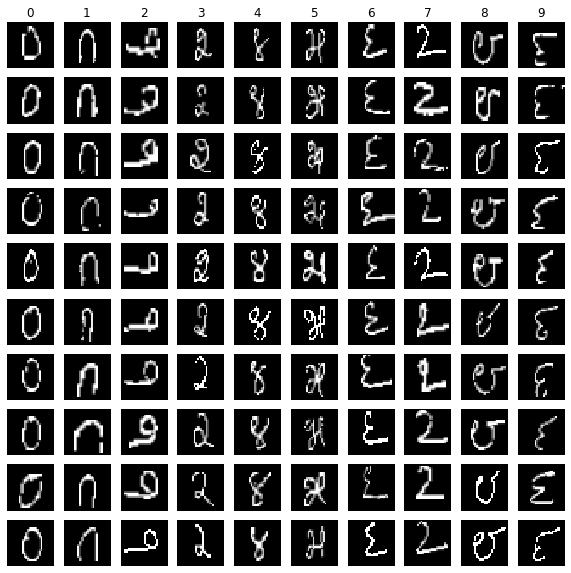

In [38]:
# Visualization Reference Kernel https://www.kaggle.com/josephvm/kannada-with-pytorch
# Some quick data visualization 
# First 10 images of each class in the training set

fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(10,10))

# I know these for loops look weird, but this way num_i is only computed once for each class
for i in range(10): # Column by column
    num_i = X_train[y_train == i]
    ax[0][i].set_title(i)
    for j in range(10): # Row by row
        ax[j][i].axis('off')
        ax[j][i].imshow(num_i.iloc[j, :].to_numpy().astype(np.uint8).reshape(28, 28), cmap='gray')

In [39]:
class CharData(Dataset):
    """
    Infer from standard PyTorch Dataset class
    Such datasets are often very useful
    """
    def __init__(self,
                 images,
                 labels=None,
                 transform=None,
                ):
        self.X = images
        self.y = labels
        
        self.transform = transform
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = np.array(self.X.iloc[idx, :], dtype='uint8').reshape([28, 28, 1])
        if self.transform is not None:
            img = self.transform(img)
        
        if self.y is not None:
            y = np.zeros(10, dtype='float32')
            y[self.y.iloc[idx]] = 1
            return img, y
        else:
            return img


In [40]:
# Put some augmentation on training data
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=5),
    transforms.ToTensor()
])

# Test data without augmentation
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

In [41]:
# Create dataset objects
train_dataset = CharData(X_train, y_train, train_transform)
dev_dataset = CharData(X_dev, y_dev, test_transform)
test_dataset = CharData(X_test, transform=test_transform)


In [42]:
# Create data generators - they will produce batches
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
dev_loader = DataLoader(dataset=dev_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [55]:
next(iter(train_loader))

tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

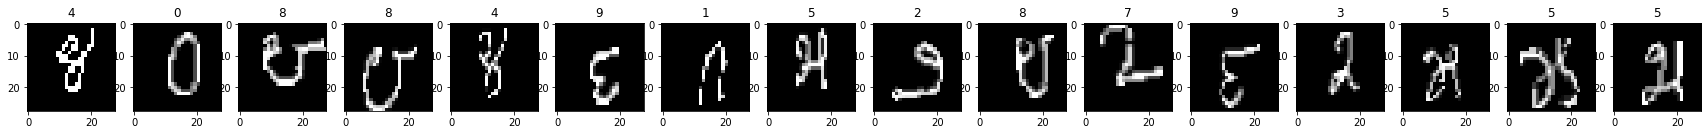

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=16, figsize=(30,4))

for batch in train_loader:
    for i in range(16):
        ax[i].set_title(batch[1][i].data.numpy().argmax())
        ax[i].imshow(batch[0][i, 0], cmap='gray')
    break